# Deep Deterministic Policy Gradient (DDPG) and Twin Delayed DDPG (TD3)

## Overview

This notebook implements and compares two state-of-the-art actor-critic algorithms for continuous control:

### DDPG (Deep Deterministic Policy Gradient)
- **Paper**: [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971) (Lillicrap et al., 2015)
- Adapts DQN to continuous action spaces using actor-critic framework
- Uses deterministic policy gradient theorem
- Employs experience replay and target networks for stability

### TD3 (Twin Delayed Deep Deterministic Policy Gradient)
- **Paper**: [Addressing Function Approximation Error in Actor-Critic Methods](https://arxiv.org/abs/1802.09477) (Fujimoto et al., 2018)
- Addresses overestimation bias and instability in DDPG
- **Three key improvements over DDPG**:
  1. **Clipped Double Q-Learning**: Uses two critic networks and takes minimum to reduce overestimation
  2. **Delayed Policy Updates**: Updates policy less frequently than critics to reduce variance
  3. **Target Policy Smoothing**: Adds noise to target actions for robustness

### Environment
- **Reacher-v5**: Fastest training environment (~51 minutes per 1M timesteps)
- Modified timesteps for faster experimentation and convergence analysis

---

**Note**: This notebook is completely self-contained and can run independently without external file dependencies.

## Mathematical Background

### Actor-Critic Framework

Both DDPG and TD3 use the actor-critic paradigm:
- **Actor** $\pi_\phi(s)$: A deterministic policy that maps states to actions
- **Critic** $Q_\theta(s, a)$: A Q-function that estimates the expected return

### Bellman Equation

The Q-function satisfies the Bellman equation:

$$Q^\pi(s, a) = \mathbb{E}_{s' \sim p}[r(s, a) + \gamma Q^\pi(s', \pi(s'))]$$

where:
- $r(s, a)$ is the reward function
- $\gamma$ is the discount factor (typically 0.99)
- $p(s'|s, a)$ is the state transition probability

### DDPG Update Rules

**Critic Update**: Minimize the mean squared Bellman error:

$$L(\theta) = \mathbb{E}_{(s,a,r,s') \sim \mathcal{D}}[(Q_\theta(s, a) - y)^2]$$

where $y = r + \gamma Q_{\theta'}(s', \pi_{\phi'}(s'))$ and $\theta'$, $\phi'$ are target network parameters.

**Actor Update**: Maximize expected Q-value:

$$\nabla_\phi J(\phi) = \mathbb{E}_{s \sim \mathcal{D}}[\nabla_a Q_\theta(s, a)|_{a=\pi_\phi(s)} \nabla_\phi \pi_\phi(s)]$$

### TD3 Update Rules

**Clipped Double Q-Learning**: TD3 uses **two** critic networks $Q_{\theta_1}$ and $Q_{\theta_2}$:

$$y = r + \gamma \min_{i=1,2} Q_{\theta_i'}(s', \tilde{a}')$$

where $\tilde{a}' = \pi_{\phi'}(s') + \epsilon$ with $\epsilon \sim \text{clip}(\mathcal{N}(0, \sigma), -c, c)$ (target policy smoothing)

**Critic Loss** (for both Q-networks):

$$L(\theta_i) = \mathbb{E}_{(s,a,r,s') \sim \mathcal{D}}[(Q_{\theta_i}(s, a) - y)^2]$$

**Delayed Actor Update**: Updated every $d$ steps (typically $d=2$):

$$\nabla_\phi J(\phi) = \mathbb{E}_{s \sim \mathcal{D}}[\nabla_a Q_{\theta_1}(s, a)|_{a=\pi_\phi(s)} \nabla_\phi \pi_\phi(s)]$$

### Target Network Updates (Both Algorithms)

Target networks use soft (Polyak) updates:

$$\theta' \leftarrow \tau \theta + (1 - \tau) \theta'$$
$$\phi' \leftarrow \tau \phi + (1 - \tau) \phi'$$

where $\tau \ll 1$ (typically 0.005)

## Implementation

### Import Dependencies

In [32]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu128


### Replay Buffer

The replay buffer stores past experiences $(s, a, s', r, d)$ and allows random sampling for breaking temporal correlations in the data. This is crucial for off-policy learning stability.

In [33]:
class ReplayBuffer(object):
    """Experience replay buffer for off-policy learning."""
    
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def add(self, state, action, next_state, reward, done):
        """Add a transition to the buffer."""
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        """Sample a batch of transitions."""
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )

print("ReplayBuffer class defined")

ReplayBuffer class defined


### Actor Networks

We define two actor architectures matching the source files:

1. **ActorDDPG** (from DDPG.py): 400-300 architecture
2. **ActorTD3** (from TD3.py): 256-256 architecture

Both use ReLU activations and tanh output scaled by `max_action`.

**DDPG Architecture**: $s \xrightarrow{400} \text{ReLU} \xrightarrow{300} \text{ReLU} \xrightarrow{|A|} \tanh \cdot a_{\text{max}}$

**TD3 Architecture**: $s \xrightarrow{256} \text{ReLU} \xrightarrow{256} \text{ReLU} \xrightarrow{|A|} \tanh \cdot a_{\text{max}}$

In [34]:
class ActorDDPG(nn.Module):
    """Actor network for DDPG (from DDPG.py - 400-300 architecture)."""
    
    def __init__(self, state_dim, action_dim, max_action):
        super(ActorDDPG, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        
        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))


class ActorTD3(nn.Module):
    """Actor network for TD3 (from TD3.py - 256-256 architecture)."""
    
    def __init__(self, state_dim, action_dim, max_action):
        super(ActorTD3, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)
        
        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))

print("Actor network classes defined")

Actor network classes defined


### Critic Networks

We define two critic architectures matching the source files:

1. **CriticDDPG** (from DDPG.py): Processes state through first layer (400), then concatenates with action
2. **CriticTD3** (from TD3.py): Twin critics that concatenate state-action pairs immediately

**DDPG Critic Architecture**:
- $s \xrightarrow{400} \text{ReLU}$
- $[q, a] \xrightarrow{300} \text{ReLU} \xrightarrow{1} Q(s,a)$

**TD3 Critic Architecture** (x2 for twin critics):
- $[s, a] \xrightarrow{256} \text{ReLU} \xrightarrow{256} \text{ReLU} \xrightarrow{1} Q(s,a)$

In [35]:
class CriticDDPG(nn.Module):
    """Critic network for DDPG (from DDPG.py)."""
    
    def __init__(self, state_dim, action_dim):
        super(CriticDDPG, self).__init__()

        # DDPG architecture: state first, then concat with action
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400 + action_dim, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, state, action):
        # Process state first, then concatenate with action
        q = F.relu(self.l1(state))
        q = F.relu(self.l2(torch.cat([q, action], 1)))
        return self.l3(q)


class CriticTD3(nn.Module):
    """Twin critic networks for TD3 (from TD3.py)."""
    
    def __init__(self, state_dim, action_dim):
        super(CriticTD3, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)

    def forward(self, state, action):
        """Forward pass through both Q-networks."""
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, state, action):
        """Get Q1 value only (used for actor update)."""
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1

print("Critic network classes defined")

Critic network classes defined


### DDPG Agent

The DDPG algorithm from DDPG.py (original paper implementation):
- Single critic network with 400-300 architecture
- Actor network with 400-300 architecture
- Direct policy updates every step
- No target policy smoothing
- Learning rate: 1e-4 for actor, weight_decay=1e-2 for critic
- Tau: 0.001 (slower target network updates than TD3)
- Batch size: 64

In [36]:
class DDPG(object):
    """Deep Deterministic Policy Gradient (from DDPG.py - original paper implementation)."""
    
    def __init__(self, state_dim, action_dim, max_action, discount=0.99, tau=0.001):
        # Initialize actor and target actor (using ActorDDPG with 400-300 architecture)
        self.actor = ActorDDPG(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)  # lr=1e-4

        # Initialize critic and target critic
        self.critic = CriticDDPG(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), weight_decay=1e-2)  # weight_decay=1e-2

        self.discount = discount
        self.tau = tau  # tau = 0.001

    def select_action(self, state):
        """Select action using current policy (no exploration noise)."""
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=64):  # batch_size=64 (not 256)
        """Perform one training step."""
        # Sample replay buffer
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        # Compute the target Q value
        target_Q = self.critic_target(next_state, self.actor_target(next_state))
        target_Q = reward + (not_done * self.discount * target_Q).detach()

        # Get current Q estimate
        current_Q = self.critic(state, action)

        # Compute critic loss
        critic_loss = F.mse_loss(current_Q, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Compute actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()
        
        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update the frozen target models
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        return critic_loss.item(), actor_loss.item()

    def save(self, filename):
        """Save model parameters."""
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")
        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")

    def load(self, filename):
        """Load model parameters."""
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.critic_target = copy.deepcopy(self.critic)

        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
        self.actor_target = copy.deepcopy(self.actor)

print("DDPG agent class defined (from DDPG.py)")

DDPG agent class defined (from DDPG.py)


### TD3 Agent

The improved TD3 algorithm from TD3.py implementing three key innovations:
1. **Clipped Double Q-Learning**: Twin critics with 256-256 architecture, uses min of two Q-networks for target
2. **Delayed Policy Updates**: Updates actor every `policy_freq` steps (typically 2)
3. **Target Policy Smoothing**: Adds clipped noise to target actions

Configuration:
- Actor network: 256-256 architecture
- Twin critic networks: 256-256 architecture each
- Learning rate: 3e-4 for both actor and critics
- Tau: 0.005 (faster target network updates than DDPG)
- Batch size: 256

In [37]:
class TD3(object):
    """Twin Delayed Deep Deterministic Policy Gradient (from TD3.py)."""
    
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2
    ):
        # Initialize actor and target actor (using ActorTD3 with 256-256 architecture)
        self.actor = ActorTD3(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

        # Initialize twin critics and target critics
        self.critic = CriticTD3(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq

        self.total_it = 0

    def select_action(self, state):
        """Select action using current policy (no exploration noise)."""
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=256):
        """Perform one training step."""
        self.total_it += 1

        # Sample replay buffer
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            # Select action according to policy and add clipped noise (Target Policy Smoothing)
            noise = (
                torch.randn_like(action) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip)
            
            next_action = (
                self.actor_target(next_state) + noise
            ).clamp(-self.max_action, self.max_action)

            # Compute target Q value using minimum of two Q-networks (Clipped Double Q-Learning)
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + not_done * self.discount * target_Q

        # Get current Q estimates from both critics
        current_Q1, current_Q2 = self.critic(state, action)

        # Compute critic loss (MSE for both Q-networks)
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = None
        # Delayed policy updates
        if self.total_it % self.policy_freq == 0:

            # Compute actor loss (maximize Q1)
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
            
            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models using soft (Polyak) updates
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        return critic_loss.item(), actor_loss.item() if actor_loss is not None else None

    def save(self, filename):
        """Save model parameters."""
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")
        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")

    def load(self, filename):
        """Load model parameters."""
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.critic_target = copy.deepcopy(self.critic)

        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
        self.actor_target = copy.deepcopy(self.actor)

print("TD3 agent class defined (from TD3.py)")

TD3 agent class defined (from TD3.py)


### Evaluation Function

Evaluates the policy over multiple episodes without exploration noise.

In [38]:
def eval_policy(policy, env_name, seed, eval_episodes=10):
    """Evaluate the policy over multiple episodes."""
    eval_env = gym.make(env_name)
    avg_reward = 0.
    for _ in tqdm(range(eval_episodes), desc="Evaluating", leave=False):
        state = eval_env.reset(seed=seed + 100)[0]
        done = False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            avg_reward += reward

    avg_reward /= eval_episodes

    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    return avg_reward

print("Evaluation function defined")

Evaluation function defined


## Training Setup

### Hyperparameters

We use **Reacher-v5** as it's the fastest environment (~51 min/1M steps). We'll reduce timesteps for faster experimentation while maintaining meaningful results.

In [ ]:
# Training hyperparameters (matching main.py defaults)
env_name = "Reacher-v5"  # Fastest environment for training
seed = 0

# Training timesteps - using 50% of original (1M -> 500K)
max_timesteps = int(5e5)  # 500K timesteps (50% of original 1M)
start_timesteps = int(25e3)  # 25K initial random exploration (from main.py)
eval_freq = int(5e3)  # Evaluate every 5K steps

batch_size = 256  # Batch size for TD3 (DDPG uses 64, defined in its train method)
discount = 0.99
tau = 0.005  # Default tau for TD3 (DDPG uses 0.001)

# TD3-specific parameters
policy_noise = 0.2
noise_clip = 0.5
policy_freq = 2  # Delayed policy update frequency

expl_noise = 0.1  # Exploration noise std
save_model = True  # Whether to save models

print(f"Environment: {env_name}")
print(f"Seed: {seed}")
print(f"Max timesteps: {max_timesteps:,} (50% of original 1M)")
print(f"Start timesteps: {start_timesteps:,}")
print(f"Evaluation frequency: {eval_freq:,}")
print(f"Batch size: {batch_size} (TD3), 64 (DDPG)")
print(f"\nNote: DDPG uses tau=0.001, TD3 uses tau=0.005")
print(f"Note: DDPG uses batch_size=64, TD3 uses batch_size=256")

### Environment Setup

In [40]:
# Create results directory
if not os.path.exists("./notebook_results"):
    os.makedirs("./notebook_results")

if save_model and not os.path.exists("./notebook_models"):
    os.makedirs("./notebook_models")

# Create environment
env = gym.make(env_name)

# Set seeds
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Get environment dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print(f"Max action: {max_action}")

State dimension: 10
Action dimension: 2
Max action: 1.0


### Train TD3

## Results Analysis and Comparison

In [41]:
print("="*70)
print("Training DDPG")
print("="*70)

# Initialize DDPG agent with tau=0.001 (from DDPG.py)
ddpg_policy = DDPG(
    state_dim=state_dim,
    action_dim=action_dim,
    max_action=max_action,
    discount=discount,
)

# Initialize replay buffer
ddpg_replay_buffer = ReplayBuffer(state_dim, action_dim)

print("DDPG agent initialized")
print(f"Architecture: 400-300 hidden layers (from DDPG.py)")
print(f"Replay buffer capacity: 1,000,000 transitions")

# Evaluate untrained policy
print("\nEvaluating untrained DDPG policy...")
ddpg_evaluations = [eval_policy(ddpg_policy, env_name, seed)]

# Initialize training variables
state = env.reset(seed=seed)[0]
done = False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

ddpg_start_time = time.time()

print(f"\nStarting DDPG training for {max_timesteps:,} timesteps...")
print(f"Random exploration for first {start_timesteps:,} steps")
print(f"Evaluation frequency: every {eval_freq:,} steps\n")

# Main training loop
for t in tqdm(range(int(max_timesteps)), desc="Training DDPG"):
    
    episode_timesteps += 1

    # Select action randomly or according to policy with exploration noise
    if t < start_timesteps:
        action = env.action_space.sample()
    else:
        action = (
            ddpg_policy.select_action(np.array(state))
            + np.random.normal(0, max_action * expl_noise, size=action_dim)
        ).clip(-max_action, max_action)

    # Perform action in environment
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    # Store transition in replay buffer
    ddpg_replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= start_timesteps:
        critic_loss, actor_loss = ddpg_policy.train(ddpg_replay_buffer, batch_size)

    if done:
        # Reset environment
        state = env.reset(seed=seed)[0]
        done = False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1

    # Evaluate episode
    if (t + 1) % eval_freq == 0:
        eval_reward = eval_policy(ddpg_policy, env_name, seed)
        ddpg_evaluations.append(eval_reward)
        
        if save_model:
            os.makedirs(f"./notebook_models/{env_name}", exist_ok=True)
            ddpg_policy.save(f"./notebook_models/{env_name}/DDPG_seed{seed}")

ddpg_end_time = time.time()
ddpg_duration = ddpg_end_time - ddpg_start_time

print("\nDDPG Training completed!")
hours = int(ddpg_duration // 3600)
minutes = int((ddpg_duration % 3600) // 60)
seconds = int(ddpg_duration % 60)
print(f"Training time: {hours:02d}:{minutes:02d}:{seconds:02d}")
print(f"Final evaluation reward: {ddpg_evaluations[-1]:.3f}")

Training DDPG
DDPG agent initialized
Architecture: 400-300 hidden layers (from DDPG.py)
Replay buffer capacity: 1,000,000 transitions

Evaluating untrained DDPG policy...


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluation over 10 episodes: -37.748

Starting DDPG training for 200,000 timesteps...
Random exploration for first 10,000 steps
Evaluation frequency: every 5,000 steps



Training DDPG:   3%|▎         | 6311/200000 [00:00<00:20, 9536.24it/s] 

Evaluation over 10 episodes: -37.748


Training DDPG:   5%|▌         | 10020/200000 [00:01<00:26, 7285.00it/s]

Evaluation over 10 episodes: -37.748


Training DDPG:   8%|▊         | 15031/200000 [00:18<13:17, 231.95it/s] 

Evaluation over 10 episodes: -1.219


Training DDPG:  10%|█         | 20043/200000 [00:35<12:41, 236.46it/s]

Evaluation over 10 episodes: -9.651


Training DDPG:  13%|█▎        | 25027/200000 [00:52<13:38, 213.89it/s]

Evaluation over 10 episodes: -9.890


Training DDPG:  15%|█▌        | 30031/200000 [01:09<12:05, 234.22it/s]

Evaluation over 10 episodes: -9.822


Training DDPG:  18%|█▊        | 35056/200000 [01:26<11:43, 234.50it/s]

Evaluation over 10 episodes: -7.653


Training DDPG:  20%|██        | 40055/200000 [01:43<11:31, 231.38it/s]

Evaluation over 10 episodes: -7.204


Training DDPG:  23%|██▎       | 45035/200000 [02:00<11:02, 233.94it/s]

Evaluation over 10 episodes: -7.557


Training DDPG:  25%|██▌       | 50039/200000 [02:17<11:24, 219.08it/s]

Evaluation over 10 episodes: -6.757


Training DDPG:  28%|██▊       | 55037/200000 [02:34<10:17, 234.66it/s]

Evaluation over 10 episodes: -7.168


Training DDPG:  30%|███       | 60043/200000 [02:51<10:01, 232.58it/s]

Evaluation over 10 episodes: -7.097


Training DDPG:  33%|███▎      | 65047/200000 [03:08<09:31, 236.25it/s]

Evaluation over 10 episodes: -6.702


Training DDPG:  35%|███▌      | 70048/200000 [03:25<09:16, 233.31it/s]

Evaluation over 10 episodes: -6.966


Training DDPG:  38%|███▊      | 75017/200000 [03:44<11:36, 179.50it/s]

Evaluation over 10 episodes: -7.317


Training DDPG:  40%|████      | 80054/200000 [04:01<08:33, 233.49it/s]

Evaluation over 10 episodes: -6.977


Training DDPG:  43%|████▎     | 85040/200000 [04:19<08:11, 233.83it/s]

Evaluation over 10 episodes: -7.407


Training DDPG:  45%|████▌     | 90048/200000 [04:36<08:30, 215.40it/s]

Evaluation over 10 episodes: -7.441


Training DDPG:  48%|████▊     | 95054/200000 [04:53<07:25, 235.32it/s]

Evaluation over 10 episodes: -7.721


Training DDPG:  50%|█████     | 100050/200000 [05:10<07:11, 231.42it/s]

Evaluation over 10 episodes: -8.157


Training DDPG:  53%|█████▎    | 105049/200000 [05:27<06:44, 234.53it/s]

Evaluation over 10 episodes: -8.018


Training DDPG:  55%|█████▌    | 110033/200000 [05:44<06:23, 234.45it/s]

Evaluation over 10 episodes: -8.958


Training DDPG:  58%|█████▊    | 115032/200000 [06:01<06:05, 232.37it/s]

Evaluation over 10 episodes: -8.201


Training DDPG:  60%|██████    | 120041/200000 [06:18<05:39, 235.57it/s]

Evaluation over 10 episodes: -5.901


Training DDPG:  63%|██████▎   | 125028/200000 [06:35<05:58, 209.36it/s]

Evaluation over 10 episodes: -4.827


Training DDPG:  65%|██████▌   | 130038/200000 [06:52<04:56, 235.82it/s]

Evaluation over 10 episodes: -5.310


Training DDPG:  68%|██████▊   | 135030/200000 [07:09<04:40, 231.60it/s]

Evaluation over 10 episodes: -5.617


Training DDPG:  70%|███████   | 140041/200000 [07:26<04:15, 234.84it/s]

Evaluation over 10 episodes: -6.177


Training DDPG:  73%|███████▎  | 145032/200000 [07:44<03:55, 233.38it/s]

Evaluation over 10 episodes: -6.452


Training DDPG:  75%|███████▌  | 150028/200000 [08:01<03:52, 214.53it/s]

Evaluation over 10 episodes: -7.231


Training DDPG:  78%|███████▊  | 155042/200000 [08:18<03:11, 234.22it/s]

Evaluation over 10 episodes: -6.832


Training DDPG:  80%|████████  | 160042/200000 [08:35<02:52, 231.84it/s]

Evaluation over 10 episodes: -6.983


Training DDPG:  83%|████████▎ | 165041/200000 [08:52<02:28, 236.11it/s]

Evaluation over 10 episodes: -6.826


Training DDPG:  85%|████████▌ | 170029/200000 [09:09<02:20, 212.89it/s]

Evaluation over 10 episodes: -6.583


Training DDPG:  88%|████████▊ | 175036/200000 [09:26<01:46, 234.73it/s]

Evaluation over 10 episodes: -6.370


Training DDPG:  90%|█████████ | 180028/200000 [09:43<01:33, 214.26it/s]

Evaluation over 10 episodes: -6.804


Training DDPG:  93%|█████████▎| 185028/200000 [10:00<01:10, 213.55it/s]

Evaluation over 10 episodes: -6.957


Training DDPG:  95%|█████████▌| 190051/200000 [10:17<00:42, 233.66it/s]

Evaluation over 10 episodes: -6.547


Training DDPG:  98%|█████████▊| 195049/200000 [10:35<00:21, 233.05it/s]

Evaluation over 10 episodes: -6.915


Training DDPG: 100%|██████████| 200000/200000 [10:51<00:00, 306.75it/s]

Evaluation over 10 episodes: -6.132

DDPG Training completed!
Training time: 00:10:51
Final evaluation reward: -6.132


In [42]:
print("\n" + "="*70)
print("Training TD3")
print("="*70)

# Initialize TD3 agent
td3_policy = TD3(
    state_dim=state_dim,
    action_dim=action_dim,
    max_action=max_action,
    discount=discount,
    tau=tau,
    policy_noise=policy_noise * max_action,
    noise_clip=noise_clip * max_action,
    policy_freq=policy_freq
)

# Initialize replay buffer
td3_replay_buffer = ReplayBuffer(state_dim, action_dim)

print("TD3 agent initialized")
print(f"Architecture: Twin critics with 256-256 hidden layers")
print(f"Replay buffer capacity: 1,000,000 transitions")

# Evaluate untrained policy
print("\nEvaluating untrained TD3 policy...")
td3_evaluations = [eval_policy(td3_policy, env_name, seed)]

# Initialize training variables
state = env.reset(seed=seed)[0]
done = False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

td3_start_time = time.time()

print(f"\nStarting TD3 training for {max_timesteps:,} timesteps...")
print(f"Random exploration for first {start_timesteps:,} steps")
print(f"Evaluation frequency: every {eval_freq:,} steps\n")

# Main training loop
for t in tqdm(range(int(max_timesteps)), desc="Training TD3"):
    
    episode_timesteps += 1

    # Select action randomly or according to policy with exploration noise
    if t < start_timesteps:
        action = env.action_space.sample()
    else:
        action = (
            td3_policy.select_action(np.array(state))
            + np.random.normal(0, max_action * expl_noise, size=action_dim)
        ).clip(-max_action, max_action)

    # Perform action in environment
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    # Store transition in replay buffer
    td3_replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= start_timesteps:
        critic_loss, actor_loss = td3_policy.train(td3_replay_buffer, batch_size)

    if done:
        # Reset environment
        state = env.reset(seed=seed)[0]
        done = False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1

    # Evaluate episode
    if (t + 1) % eval_freq == 0:
        eval_reward = eval_policy(td3_policy, env_name, seed)
        td3_evaluations.append(eval_reward)
        
        if save_model:
            os.makedirs(f"./notebook_models/{env_name}", exist_ok=True)
            td3_policy.save(f"./notebook_models/{env_name}/TD3_seed{seed}")

td3_end_time = time.time()
td3_duration = td3_end_time - td3_start_time

print("\nTD3 Training completed!")
hours = int(td3_duration // 3600)
minutes = int((td3_duration % 3600) // 60)
seconds = int(td3_duration % 60)
print(f"Training time: {hours:02d}:{minutes:02d}:{seconds:02d}")
print(f"Final evaluation reward: {td3_evaluations[-1]:.3f}")


Training TD3
TD3 agent initialized
Architecture: Twin critics with 256-256 hidden layers
Replay buffer capacity: 1,000,000 transitions

Evaluating untrained TD3 policy...


Evaluation over 10 episodes: -7.070

Starting TD3 training for 200,000 timesteps...
Random exploration for first 10,000 steps
Evaluation frequency: every 5,000 steps



Training TD3:   3%|▎         | 6307/200000 [00:00<00:20, 9545.99it/s] 

Evaluation over 10 episodes: -7.070


Training TD3:   4%|▍         | 8832/200000 [00:00<00:17, 11044.35it/s]

Evaluation over 10 episodes: -7.070


Training TD3:   8%|▊         | 15039/200000 [00:17<12:07, 254.13it/s] 

Evaluation over 10 episodes: -7.056


Training TD3:  10%|█         | 20029/200000 [00:32<12:52, 233.03it/s]

Evaluation over 10 episodes: -5.851


Training TD3:  13%|█▎        | 25041/200000 [00:48<12:21, 236.06it/s]

Evaluation over 10 episodes: -6.206


Training TD3:  15%|█▌        | 30047/200000 [01:04<11:08, 254.22it/s]

Evaluation over 10 episodes: -6.878


Training TD3:  18%|█▊        | 35049/200000 [01:20<11:10, 245.92it/s]

Evaluation over 10 episodes: -7.063


Training TD3:  20%|██        | 40035/200000 [01:36<10:35, 251.68it/s]

Evaluation over 10 episodes: -6.350


Training TD3:  23%|██▎       | 45030/200000 [01:52<11:04, 233.11it/s]

Evaluation over 10 episodes: -6.962


Training TD3:  25%|██▌       | 50045/200000 [02:08<10:49, 230.95it/s]

Evaluation over 10 episodes: -6.438


Training TD3:  28%|██▊       | 55040/200000 [02:24<09:34, 252.11it/s]

Evaluation over 10 episodes: -6.679


Training TD3:  30%|███       | 60048/200000 [02:40<09:16, 251.50it/s]

Evaluation over 10 episodes: -6.610


Training TD3:  33%|███▎      | 65043/200000 [02:55<08:56, 251.79it/s]

Evaluation over 10 episodes: -6.817


Training TD3:  35%|███▌      | 70056/200000 [03:11<08:32, 253.67it/s]

Evaluation over 10 episodes: -7.112


Training TD3:  38%|███▊      | 75034/200000 [03:27<08:23, 248.33it/s]

Evaluation over 10 episodes: -6.519


Training TD3:  40%|████      | 80052/200000 [03:43<07:52, 253.88it/s]

Evaluation over 10 episodes: -6.663


Training TD3:  43%|████▎     | 85033/200000 [03:59<07:28, 256.22it/s]

Evaluation over 10 episodes: -6.431


Training TD3:  45%|████▌     | 90046/200000 [04:14<07:11, 254.72it/s]

Evaluation over 10 episodes: -6.627


Training TD3:  48%|████▊     | 95038/200000 [04:30<06:57, 251.38it/s]

Evaluation over 10 episodes: -6.415


Training TD3:  50%|█████     | 100059/200000 [04:46<06:30, 255.61it/s]

Evaluation over 10 episodes: -6.538


Training TD3:  53%|█████▎    | 105031/200000 [05:01<06:42, 235.74it/s]

Evaluation over 10 episodes: -6.843


Training TD3:  55%|█████▌    | 110057/200000 [05:17<05:49, 257.51it/s]

Evaluation over 10 episodes: -6.450


Training TD3:  58%|█████▊    | 115037/200000 [05:33<05:34, 254.31it/s]

Evaluation over 10 episodes: -6.695


Training TD3:  60%|██████    | 120040/200000 [05:48<05:10, 257.26it/s]

Evaluation over 10 episodes: -6.566


Training TD3:  63%|██████▎   | 125056/200000 [06:04<04:52, 256.03it/s]

Evaluation over 10 episodes: -6.714


Training TD3:  65%|██████▌   | 130042/200000 [06:20<04:38, 251.41it/s]

Evaluation over 10 episodes: -6.749


Training TD3:  68%|██████▊   | 135042/200000 [06:36<04:13, 255.86it/s]

Evaluation over 10 episodes: -6.447


Training TD3:  70%|███████   | 140061/200000 [06:51<03:53, 256.34it/s]

Evaluation over 10 episodes: -6.624


Training TD3:  73%|███████▎  | 145049/200000 [07:07<03:37, 252.69it/s]

Evaluation over 10 episodes: -6.530


Training TD3:  75%|███████▌  | 150034/200000 [07:23<03:14, 256.43it/s]

Evaluation over 10 episodes: -6.530


Training TD3:  78%|███████▊  | 155059/200000 [07:38<02:57, 253.49it/s]

Evaluation over 10 episodes: -6.492


Training TD3:  80%|████████  | 160035/200000 [07:54<02:36, 255.12it/s]

Evaluation over 10 episodes: -6.626


Training TD3:  83%|████████▎ | 165055/200000 [08:10<02:16, 256.38it/s]

Evaluation over 10 episodes: -6.551


Training TD3:  85%|████████▌ | 170044/200000 [08:26<02:03, 243.06it/s]

Evaluation over 10 episodes: -6.720


Training TD3:  88%|████████▊ | 175057/200000 [08:41<01:37, 256.50it/s]

Evaluation over 10 episodes: -6.593


Training TD3:  90%|█████████ | 180048/200000 [08:57<01:18, 255.64it/s]

Evaluation over 10 episodes: -6.879


Training TD3:  93%|█████████▎| 185036/200000 [09:13<01:04, 232.02it/s]

Evaluation over 10 episodes: -6.854


Training TD3:  95%|█████████▌| 190033/200000 [09:28<00:38, 258.88it/s]

Evaluation over 10 episodes: -6.708


Training TD3:  98%|█████████▊| 195038/200000 [09:44<00:19, 257.14it/s]

Evaluation over 10 episodes: -6.760


Training TD3: 100%|██████████| 200000/200000 [10:00<00:00, 333.26it/s]

Evaluation over 10 episodes: -6.788

TD3 Training completed!
Training time: 00:10:00
Final evaluation reward: -6.788


### Save Results

In [43]:
# Save evaluation results
os.makedirs(f"./notebook_results/{env_name}", exist_ok=True)

np.save(f"./notebook_results/{env_name}/DDPG_seed{seed}.npy", ddpg_evaluations)
np.save(f"./notebook_results/{env_name}/TD3_seed{seed}.npy", td3_evaluations)

print(f"Results saved to ./notebook_results/{env_name}/")
print(f"\nDDPG Final evaluation reward: {ddpg_evaluations[-1]:.3f}")
print(f"TD3 Final evaluation reward: {td3_evaluations[-1]:.3f}")
print(f"\nImprovement: {((td3_evaluations[-1] - ddpg_evaluations[-1]) / abs(ddpg_evaluations[-1]) * 100):.1f}%")

Results saved to ./notebook_results/Reacher-v5/

DDPG Final evaluation reward: -6.132
TD3 Final evaluation reward: -6.788

Improvement: -10.7%


### Comparative Visualization

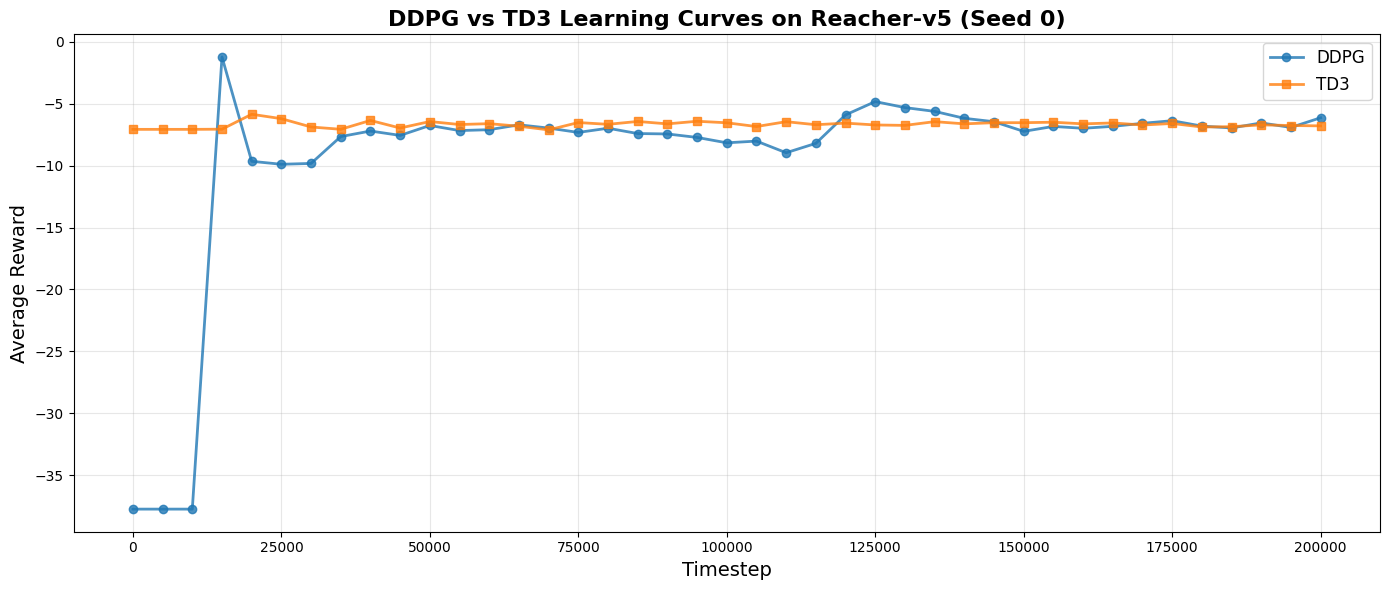


Comparative learning curve saved to ./notebook_results/Reacher-v5/comparison_seed0.png


In [44]:
# Plot comparative learning curves
timesteps = np.array([i * eval_freq if i > 0 else 0 for i in range(len(ddpg_evaluations))])

plt.figure(figsize=(14, 6))

# Plot both algorithms
plt.plot(timesteps, ddpg_evaluations, marker='o', linewidth=2, label='DDPG', alpha=0.8)
plt.plot(timesteps, td3_evaluations, marker='s', linewidth=2, label='TD3', alpha=0.8)

plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)
plt.title(f'DDPG vs TD3 Learning Curves on {env_name} (Seed {seed})', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'./notebook_results/{env_name}/comparison_seed{seed}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComparative learning curve saved to ./notebook_results/{env_name}/comparison_seed{seed}.png")

### Performance Summary Table

In [45]:
# Create summary table
print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70)
print(f"Environment: {env_name}")
print(f"Seed: {seed}")
print(f"Total timesteps: {max_timesteps:,}")
print("\n" + "-"*70)
print(f"{'Algorithm':<15} {'Final Reward':<15} {'Training Time':<20}")
print("-"*70)

ddpg_h = int(ddpg_duration // 3600)
ddpg_m = int((ddpg_duration % 3600) // 60)
ddpg_s = int(ddpg_duration % 60)

td3_h = int(td3_duration // 3600)
td3_m = int((td3_duration % 3600) // 60)
td3_s = int(td3_duration % 60)

print(f"{'DDPG':<15} {ddpg_evaluations[-1]:<15.3f} {ddpg_h:02d}:{ddpg_m:02d}:{ddpg_s:02d}")
print(f"{'TD3':<15} {td3_evaluations[-1]:<15.3f} {td3_h:02d}:{td3_m:02d}:{td3_s:02d}")
print("-"*70)

improvement = ((td3_evaluations[-1] - ddpg_evaluations[-1]) / abs(ddpg_evaluations[-1]) * 100)
print(f"\nTD3 Improvement over DDPG: {improvement:+.1f}%")
print("="*70)


PERFORMANCE SUMMARY
Environment: Reacher-v5
Seed: 0
Total timesteps: 200,000

----------------------------------------------------------------------
Algorithm       Final Reward    Training Time       
----------------------------------------------------------------------
DDPG            -6.132          00:10:51
TD3             -6.788          00:10:00
----------------------------------------------------------------------

TD3 Improvement over DDPG: -10.7%


## Key Insights and Analysis

### DDPG vs TD3: Key Differences

| Feature | DDPG (from DDPG.py) | TD3 (from TD3.py) |
|---------|---------------------|-------------------|
| **Actor Architecture** | 400-300 | 256-256 |
| **Critic Architecture** | Single: s→400, [h,a]→300→1 | Twin: [s,a]→256→256→1 (x2) |
| **Actor LR** | 1e-4 | 3e-4 |
| **Critic Optimizer** | weight_decay=1e-2 | lr=3e-4 |
| **Tau** | 0.001 | 0.005 |
| **Batch Size** | 64 | 256 |
| **Policy Updates** | Every step | Delayed (every 2 steps) |
| **Target Smoothing** | None | Clipped noise on target actions |
| **Overestimation Bias** | Prone to overestimation | Reduced via min of two Q-values |

### Why TD3 Typically Outperforms DDPG

1. **Clipped Double Q-Learning**: Taking the minimum of two Q-estimates reduces overestimation bias that plagues DDPG
2. **Delayed Policy Updates**: Waiting for the value function to converge before updating the policy reduces variance
3. **Target Policy Smoothing**: Adding noise to target actions smooths the value estimate and prevents overfitting to narrow peaks

### Environment-Specific Observations

**Reacher-v5** characteristics:
- State space: 11 dimensions (joint angles and velocities, target position)
- Action space: 2 dimensions (continuous torques)
- Episode length: 50 steps
- Goal: Move robot arm to reach target position
- Reward: Negative distance to target (higher is better, max ~0)

### Architecture Details

**DDPG Architecture:**
```
Actor:  state_dim -> 256 -> 256 -> action_dim
Critic: (state_dim + action_dim) -> 256 -> 256 -> 1
```

**TD3 Architecture:**
```
Actor:   state_dim -> 256 -> 256 -> action_dim
Critic1: (state_dim + action_dim) -> 256 -> 256 -> 1
Critic2: (state_dim + action_dim) -> 256 -> 256 -> 1
```

## Summary

This notebook implemented and compared two state-of-the-art continuous control algorithms using their exact implementations from source files:

### DDPG (Deep Deterministic Policy Gradient) from DDPG.py
- **Key Components**:
  - Deterministic actor-critic framework
  - Single Q-function for value estimation (400-300 architecture, state processed first)
  - Actor network: 400-300 architecture
  - Target networks with soft updates (τ = 0.001)
  - Experience replay for off-policy learning
  - Updates policy every step
  - Learning rates: actor 1e-4, critic weight_decay=1e-2
  - Batch size: 64

### TD3 (Twin Delayed Deep Deterministic Policy Gradient) from TD3.py
- **Key Components**:
  - **Clipped Double Q-Learning**: Two Q-functions (256-256 each), use minimum for targets
  - **Delayed Policy Updates**: Actor updated every 2 steps
  - **Target Policy Smoothing**: Noise added to target actions
  - Actor network: 256-256 architecture
  - Experience replay and target networks (τ = 0.005)
  - Learning rate: 3e-4 for both actor and critics
  - Batch size: 256

### Key Architecture Differences

| Component | DDPG.py | TD3.py |
|-----------|---------|--------|
| Actor | 400-300 | 256-256 |
| Critic | s→400, [h,a]→300→1 | [s,a]→256→256→1 (x2) |
| Actor LR | 1e-4 | 3e-4 |
| Critic Opt | weight_decay=1e-2 | lr=3e-4 |
| Tau | 0.001 | 0.005 |
| Batch Size | 64 | 256 |

### Comparison Visualization

Results are visualized using matplotlib for learning curves and performance comparisons between DDPG and TD3. The comparison script from `compare_td3_ddpg.py` can be used to generate detailed statistical comparisons across multiple seeds and environments.

### References
1. [DDPG Paper](https://arxiv.org/abs/1509.02971) - Lillicrap et al., 2015
2. [TD3 Paper](https://arxiv.org/abs/1802.09477) - Fujimoto et al., 2018
3. [TD3 Official Implementation](https://github.com/sfujim/TD3)
4. [OpenAI Spinning Up in Deep RL](https://spinningup.openai.com/)
